<a href="https://colab.research.google.com/github/Abhiraj36/HumanEmotionsDetection/blob/main/Human_Emotions_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import tensorflow as tf
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, Conv2D, MaxPool2D, Dense
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, TopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import L2,L1
from tensorflow.keras.layers import Resizing, Rescaling

import matplotlib.pyplot as plt
import numpy as np


In [4]:
import zipfile
import os

zip_path = "/content/Human_Emotion_Dataset.zip"  # Update with correct path
extract_path = "/content/Human_Emotion_Dataset"  # Folder where it will be extracted

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")


Dataset extracted successfully!


In [9]:
dataset_path = "/content/Human_Emotion_Dataset"
train_directory = os.path.join(dataset_path, "EmotionsDataset_Splitted", "data", "train")
val_directory = os.path.join(dataset_path, "EmotionsDataset_Splitted", "data", "test")


print("Updated train path:", train_directory)
print("Updated validation path:", validation_directory)

CLASS_NAMES = ["angry", "happy", "sad"]



Updated train path: /content/Human_Emotion_Dataset/EmotionsDataset_Splitted/data/train
Updated validation path: /content/Human_Emotion_Dataset/EmotionsDataset_Splitted/data/test


In [28]:
CONFIGURATION = {
    "BATCH_SIZE" : 32,
    "IM_SIZE" : 256,
    "LEARNING_RATE" : 0.001,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 1,
    "N_STRIDES" : 1,
    "POOL_SIZE":2,
    "N_DENSE_1":100,
    "N_DENSE-2":10,
    "NUM_CLASSES" : 3,
}

In [11]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='int',
    image_size=(256, 256),
    batch_size=32,
    shuffle=True,
    seed=99,
    class_names=CLASS_NAMES,
    color_mode='rgb'
)


Found 2278 files belonging to 3 classes.


In [14]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_directory,  # Now pointing to test directory
    labels='inferred',
    label_mode='categorical',
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    batch_size=CONFIGURATION["BATCH_SIZE"],
    shuffle=True,  # Usually, we don't shuffle validation data
    seed=99,
    class_names=CLASS_NAMES,
    color_mode='rgb'
)


Found 569 files belonging to 3 classes.


In [15]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[255.      , 255.      , 251.      ],
         [255.      , 255.      , 251.      ],
         [255.      , 254.3125  , 251.6875  ],
         ...,
         [ 58.      ,  46.625   ,  46.3125  ],
         [ 54.4375  ,  44.4375  ,  43.4375  ],
         [ 39.      ,  29.      ,  28.      ]],

        [[255.      , 255.      , 251.      ],
         [255.      , 255.      , 251.      ],
         [253.88281 , 253.19531 , 250.57031 ],
         ...,
         [ 58.8125  ,  47.4375  ,  47.125   ],
         [ 55.859375,  45.859375,  44.859375],
         [ 43.0625  ,  33.0625  ,  32.0625  ]],

        [[255.      , 255.      , 251.      ],
         [255.      , 255.      , 251.      ],
         [253.625   , 253.41016 , 250.78516 ],
         ...,
         [ 59.214844,  47.839844,  47.527344],
         [ 57.132812,  47.132812,  46.132812],
         [ 46.0625  ,  36.0625  ,  35.0625  ]],

        ...,

        [[252.3125  , 254.3125  

Data Visualization

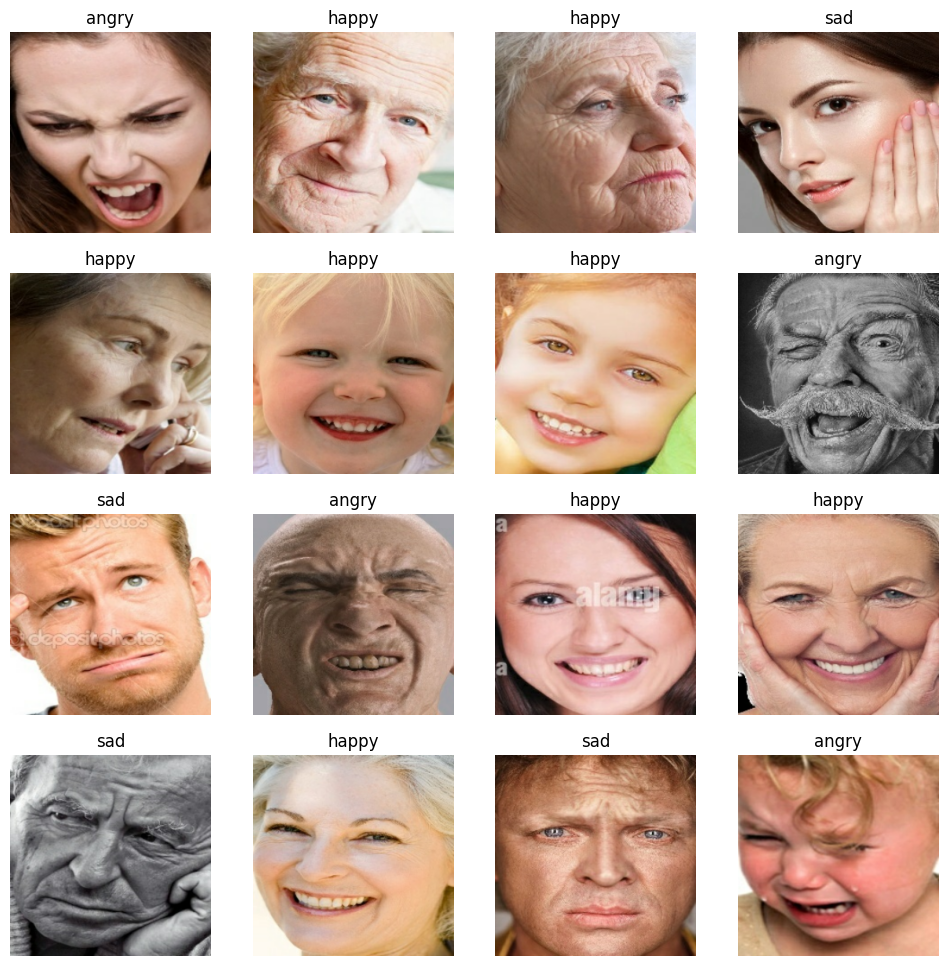

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

for images, labels in train_dataset.take(1):  # Taking one batch of images
    for i in range(min(16, len(images))):  # Display up to 16 images
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert tensor to image
        plt.title(CLASS_NAMES[labels[i].numpy()])  # Get class name
        plt.axis("off")  # Hide axes

plt.show()


Dataset Preparation

In [21]:
training_dataset = (
    train_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [22]:
validation_dataset = (
    train_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [27]:
IM_SIZE = 256  # Define the image size if not already defined

resize_rescale_layers = tf.keras.Sequential([
    Resizing(IM_SIZE, IM_SIZE),
    Rescaling(1.0 / 255),  # Normalize pixel values to [0,1]
])

Building and Applying Model

In [31]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

# Configuration dictionary
CONFIGURATION = {
    "IM_SIZE": 256,
    "N_FILTERS": 6,
    "KERNEL_SIZE": (5, 5),
    "N_STRIDES": 1,
    "POOL_SIZE": (2, 2),
    "DROPOUT_RATE": 0.25,
    "REGULARIZATION_RATE": 0.0001,
    "N_DENSE_1": 120,
    "N_DENSE_2": 84,
    "NUM_CLASSES": 3  # Adjust based on dataset
}

# Define the model
lenet_model = tf.keras.Sequential([
    layers.Input(shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3)),  # Fixed input shape warning
    layers.Rescaling(1./255, name="rescaling"),

    layers.Conv2D(filters=CONFIGURATION["N_FILTERS"], kernel_size=CONFIGURATION["KERNEL_SIZE"],
                  strides=CONFIGURATION["N_STRIDES"], activation='relu',
                  kernel_regularizer=regularizers.L2(CONFIGURATION["REGULARIZATION_RATE"])),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["N_STRIDES"] * 2),
    layers.Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),

    layers.Conv2D(filters=CONFIGURATION["N_FILTERS"] * 2 + 4, kernel_size=CONFIGURATION["KERNEL_SIZE"],
                  strides=CONFIGURATION["N_STRIDES"], activation='relu',
                  kernel_regularizer=regularizers.L2(CONFIGURATION["REGULARIZATION_RATE"])),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["N_STRIDES"] * 2),

    layers.Flatten(),

    layers.Dense(CONFIGURATION["N_DENSE_1"], activation="relu",
                 kernel_regularizer=regularizers.L2(CONFIGURATION["REGULARIZATION_RATE"])),
    layers.BatchNormalization(),
    layers.Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),

    layers.Dense(CONFIGURATION["N_DENSE_2"], activation="relu",
                 kernel_regularizer=regularizers.L2(CONFIGURATION["REGULARIZATION_RATE"])),
    layers.BatchNormalization(),

    layers.Dense(CONFIGURATION["NUM_CLASSES"], activation="softmax")
])

lenet_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy' if CONFIGURATION["NUM_CLASSES"] > 1 else 'binary_crossentropy',
                    metrics=['accuracy'])

lenet_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 252, 252, 6)         │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 252, 252, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 126, 126, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 126, 126, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 122, 122, 16)        │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 122, 122, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 61, 61, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 59536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 120)                 │       7,144,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 120)                 │             480 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 84)                  │             336 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │             255 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,158,635 (27.31 MB)

 Trainable params: 7,158,183 (27.31 MB)

 Non-trainable params: 452 (1.77 KB)